# Eploratory Data Analysis

### This notebook accomplishes the following:


---

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

---
# Section 1: DMAcademy and truezelda text analysis


### Read in the data files

In [3]:
dmacademy_df = pd.read_csv('../data/clean_dmacademy.csv')
truezelda_df = pd.read_csv('../data/clean_truezelda.csv')

### Identify potential stopwords

In [6]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
X = dmacademy_df['title'] + ' ' + dmacademy_df['text']

In [8]:
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)

In [9]:
cvec.get_feature_names()[1000:1010]

['approaches',
 'approaching',
 'appropiately',
 'appropriate',
 'appropriately',
 'appropriation',
 'approval',
 'approve',
 'approved',
 'approvement']

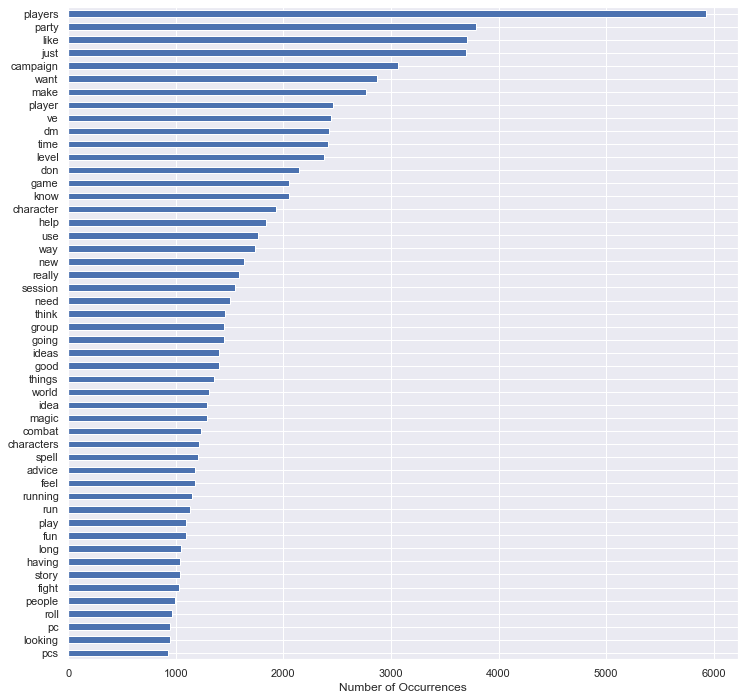

In [10]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,12))
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

Game, players, time, enemies, and world are a few words that we might consider adding to our stopwords list. These kinds of words might be showing up a lot in each file. Consider checking them against each other. 

---
### Post word count


In [11]:
dma_word_counts = [len(post.split()) for post in dmacademy_df['text']]
zelda_word_counts = [len(post.split()) for post in truezelda_df['text']]

In [12]:
dma_word_counts[:10]

[294, 697, 62, 56, 25, 172, 433, 246, 685, 557]

In [13]:
zelda_word_counts[:10]

[111, 264, 24, 201, 26, 58, 125, 1583, 1, 167]

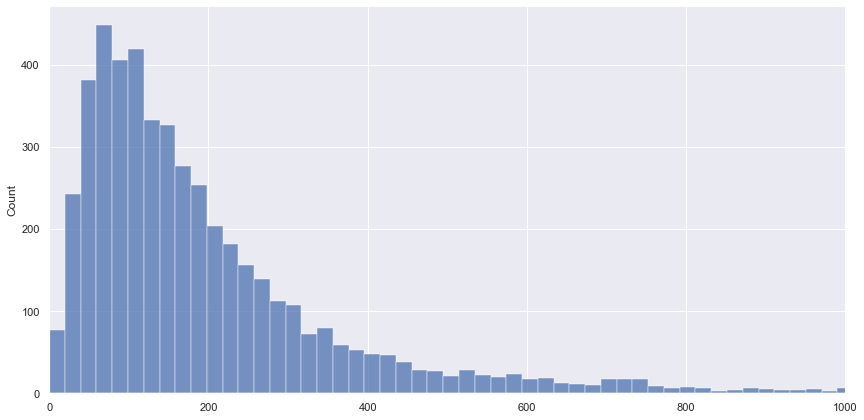

In [14]:
sns.displot(dma_word_counts, height = 6, aspect = 2, bins=175);
plt.xlim(0, 1000);

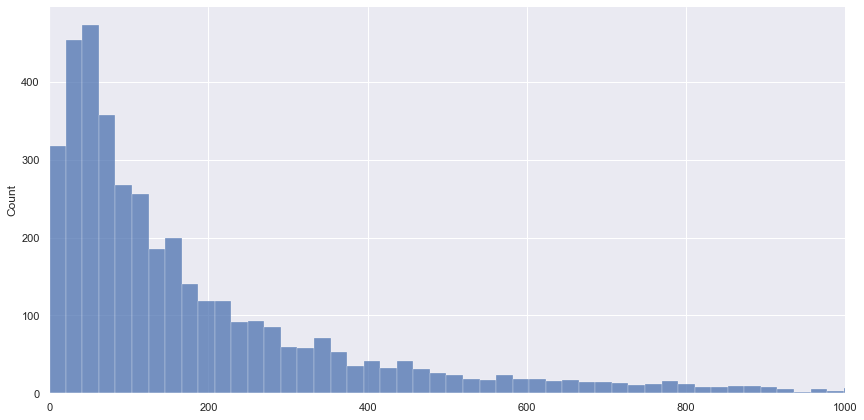

In [15]:
sns.displot(zelda_word_counts, height = 6, aspect = 2, bins=300);
plt.xlim(0, 1000);

---
### Post character length

In [16]:
dma_char_length = [len(post) for post in dmacademy_df['text']]
zelda_char_length = [len(post) for post in truezelda_df['text']]

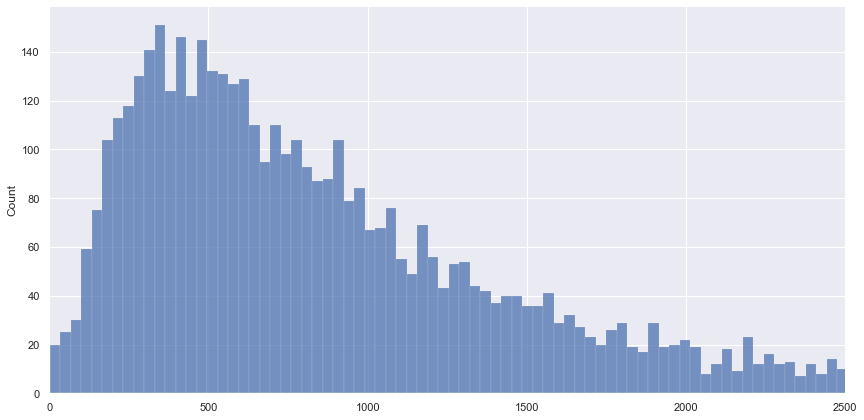

In [17]:
sns.displot(dma_char_length, height = 6, aspect = 2, bins=600);
plt.xlim(0, 2500);

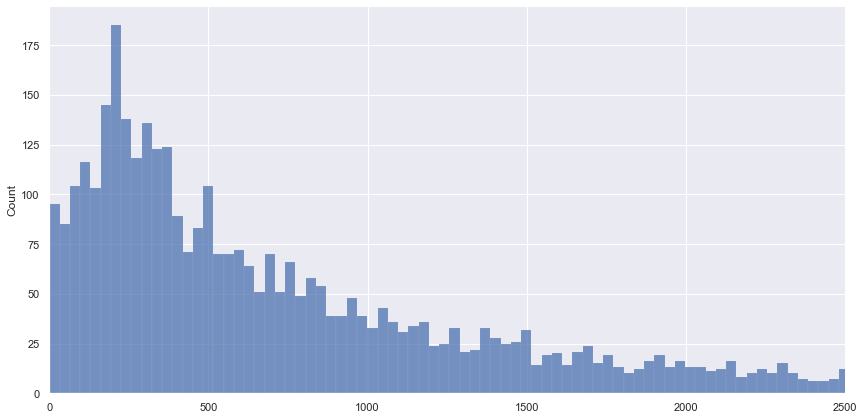

In [18]:
sns.displot(zelda_char_length, height = 6, aspect = 2, bins=1000);
plt.xlim(0, 2500);

---
### Word tokenizing example

In [19]:
import nltk
import re
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('oceanographers')

'oceanographer'

In [20]:
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag

In [21]:
dmacademy_df['text'][0]

'  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hyped for the conversations we will have I am currently going through interview applications and preparing to send out follow ups Thanks for your patience    Hello seasoned dungeon masters  I m Nick the host of an upcoming GM interview podcast and I want to talk with you on my show Isn t it about time your epic campaign gets shared with the TTRPG community  I want you the non celebrity GM  or hidden GM if you will  to share your stories and wisdom with the community I think we as a community have something to learn from your experience behind the GM screen  What makes this podcast really fun is that we ll be getting your wisdom out there to other GMs just like you This is the outlet you ve been waiting for to talk about the campaign you poured your heart and soul into I know how painful it is to keep all the cool secrets of your campaign and hidden lore from your PCs My heart is always te

In [22]:
example = dmacademy_df['text'][0]

In [23]:
print(word_tokenize(example.lower()))

['edit', 'update', 'thank', 'you', 'for', 'the', 'robust', 'response', 'i', 've', 'had', 'some', 'great', 'applications', 'so', 'far', 'and', 'i', 'm', 'hyped', 'for', 'the', 'conversations', 'we', 'will', 'have', 'i', 'am', 'currently', 'going', 'through', 'interview', 'applications', 'and', 'preparing', 'to', 'send', 'out', 'follow', 'ups', 'thanks', 'for', 'your', 'patience', 'hello', 'seasoned', 'dungeon', 'masters', 'i', 'm', 'nick', 'the', 'host', 'of', 'an', 'upcoming', 'gm', 'interview', 'podcast', 'and', 'i', 'want', 'to', 'talk', 'with', 'you', 'on', 'my', 'show', 'isn', 't', 'it', 'about', 'time', 'your', 'epic', 'campaign', 'gets', 'shared', 'with', 'the', 'ttrpg', 'community', 'i', 'want', 'you', 'the', 'non', 'celebrity', 'gm', 'or', 'hidden', 'gm', 'if', 'you', 'will', 'to', 'share', 'your', 'stories', 'and', 'wisdom', 'with', 'the', 'community', 'i', 'think', 'we', 'as', 'a', 'community', 'have', 'something', 'to', 'learn', 'from', 'your', 'experience', 'behind', 'the',

In [24]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|S+')
example_tokens = tokenizer.tokenize(example.lower())

print(example_tokens)

['edit', 'update', 'thank', 'you', 'for', 'the', 'robust', 'response', 'i', 've', 'had', 'some', 'great', 'applications', 'so', 'far', 'and', 'i', 'm', 'hyped', 'for', 'the', 'conversations', 'we', 'will', 'have', 'i', 'am', 'currently', 'going', 'through', 'interview', 'applications', 'and', 'preparing', 'to', 'send', 'out', 'follow', 'ups', 'thanks', 'for', 'your', 'patience', 'hello', 'seasoned', 'dungeon', 'masters', 'i', 'm', 'nick', 'the', 'host', 'of', 'an', 'upcoming', 'gm', 'interview', 'podcast', 'and', 'i', 'want', 'to', 'talk', 'with', 'you', 'on', 'my', 'show', 'isn', 't', 'it', 'about', 'time', 'your', 'epic', 'campaign', 'gets', 'shared', 'with', 'the', 'ttrpg', 'community', 'i', 'want', 'you', 'the', 'non', 'celebrity', 'gm', 'or', 'hidden', 'gm', 'if', 'you', 'will', 'to', 'share', 'your', 'stories', 'and', 'wisdom', 'with', 'the', 'community', 'i', 'think', 'we', 'as', 'a', 'community', 'have', 'something', 'to', 'learn', 'from', 'your', 'experience', 'behind', 'the',

In [25]:
# re.findall can find all digits in your text
# don't need to do this because we removed digits previously
# [(re.findall('\d+', word), word) for word in example_tokens]

---
### Sentiment analysis

In [28]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Derya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [29]:
sentiment = SentimentIntensityAnalyzer()

In [30]:
example

'  Edit  UPDATE  Thank you for the robust response I ve had some great applications so far and I m hyped for the conversations we will have I am currently going through interview applications and preparing to send out follow ups Thanks for your patience    Hello seasoned dungeon masters  I m Nick the host of an upcoming GM interview podcast and I want to talk with you on my show Isn t it about time your epic campaign gets shared with the TTRPG community  I want you the non celebrity GM  or hidden GM if you will  to share your stories and wisdom with the community I think we as a community have something to learn from your experience behind the GM screen  What makes this podcast really fun is that we ll be getting your wisdom out there to other GMs just like you This is the outlet you ve been waiting for to talk about the campaign you poured your heart and soul into I know how painful it is to keep all the cool secrets of your campaign and hidden lore from your PCs My heart is always te

In [31]:
sentiment.polarity_scores(example)

{'neg': 0.009, 'neu': 0.779, 'pos': 0.212, 'compound': 0.995}

In [32]:
dmacademy_sentiment = {'neg':0, 'neu':0, 'pos':0}
sample_dmacademy = dmacademy_df[:20]

# get polarity scores for each row in our dataframe
for row in sample_dmacademy['text']:
    scores = sentiment.polarity_scores(row)
    dmacademy_sentiment['neg'] += scores['neg']
    dmacademy_sentiment['neu'] += scores['neu']
    dmacademy_sentiment['pos'] += scores['pos']

# get the average for each
for key in dmacademy_sentiment.keys():
    dmacademy_sentiment[key] = dmacademy_sentiment[key]/len(sample_dmacademy)
print(dmacademy_sentiment)

# prove that these add up to close to 1
total = 0
for key in dmacademy_sentiment.keys():
    total += dmacademy_sentiment[key]
total

{'neg': 0.08295, 'neu': 0.7989500000000002, 'pos': 0.11800000000000002}


0.9999000000000001

In [33]:
def get_polarity(df):
    # create polarity dictionary
    polarity_dict = {'Negative':0, 'Neutral':0, 'Positive':0}
    
    # get polarity scores for each row in our dataframe
    for row in df['text']:
        scores = sentiment.polarity_scores(row)
        polarity_dict['Negative'] += scores['neg']
        polarity_dict['Neutral'] += scores['neu']
        polarity_dict['Positive'] += scores['pos']

    # get the average scores 
    for key in polarity_dict.keys():
        polarity_dict[key] = polarity_dict[key]/len(df)
        
    return polarity_dict

In [34]:
get_polarity(sample_dmacademy)

{'Negative': 0.08295,
 'Neutral': 0.7989500000000002,
 'Positive': 0.11800000000000002}

In [35]:
dmacademy_polarity = get_polarity(dmacademy_df)
dmacademy_polarity

{'Negative': 0.07945631266625777,
 'Neutral': 0.7892070800081862,
 'Positive': 0.1309263351749538}

In [36]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(dmacademy_polarity.keys(), dmacademy_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', 'r/DMAcademy'])

In [37]:
polarity_df

,score_type,r/DMAcademy
0,Negative,0.079456
1,Neutral,0.789207
2,Positive,0.130926


In [38]:
truezelda_polarity = get_polarity(truezelda_df)
truezelda_polarity

{'Negative': 0.05893652723735403,
 'Neutral': 0.8090695525291832,
 'Positive': 0.11982855058365775}

In [39]:
polarity_df['r/truezelda'] = list(truezelda_polarity.values())

In [40]:
polarity_df

,score_type,r/DMAcademy,r/truezelda
0,Negative,0.079456,0.058937
1,Neutral,0.789207,0.809070
2,Positive,0.130926,0.119829


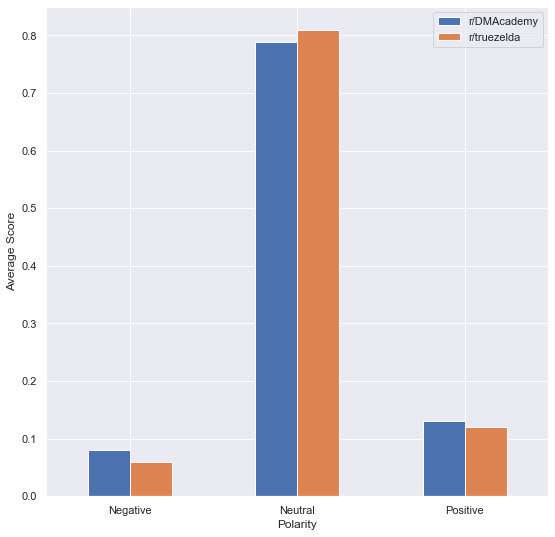

In [41]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['r/DMAcademy', 'r/truezelda'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity')
plt.ylabel('Average Score')
plt.xticks(rotation=0);

Now that we've got a small tidy dataframe of our average polarity scores for each subreddit, let's visualize! 

In [42]:
polarity_df.index

RangeIndex(start=0, stop=3, step=1)

--- 
# Section 2: PoliticalDiscussion 2012 and 2020 text analysis

### Read in the data files

In [51]:
poli_dis_2012_df = pd.read_csv('../data/clean_poli_dis_2012.csv')
poli_dis_2020_df = pd.read_csv('../data/clean_poli_dis_2020.csv')

### Identify potential stopwords

In [52]:
poli_dis_2012_df.isnull().sum()

subreddit    0
text         1
dtype: int64

In [54]:
poli_dis_2012_df.dropna(inplace=True)
poli_dis_2012_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [55]:
poli_dis_2020_df.isnull().sum()

subreddit    0
text         0
dtype: int64

In [56]:
X = poli_dis_2012_df['text']

In [58]:
cvec = CountVectorizer(stop_words='english')
X = cvec.fit_transform(X)

In [59]:
cvec.get_feature_names()[1000:1010]

['baked',
 'balance',
 'balanced',
 'balances',
 'balancing',
 'baldus',
 'bales',
 'balkanization',
 'ball',
 'ballistic']

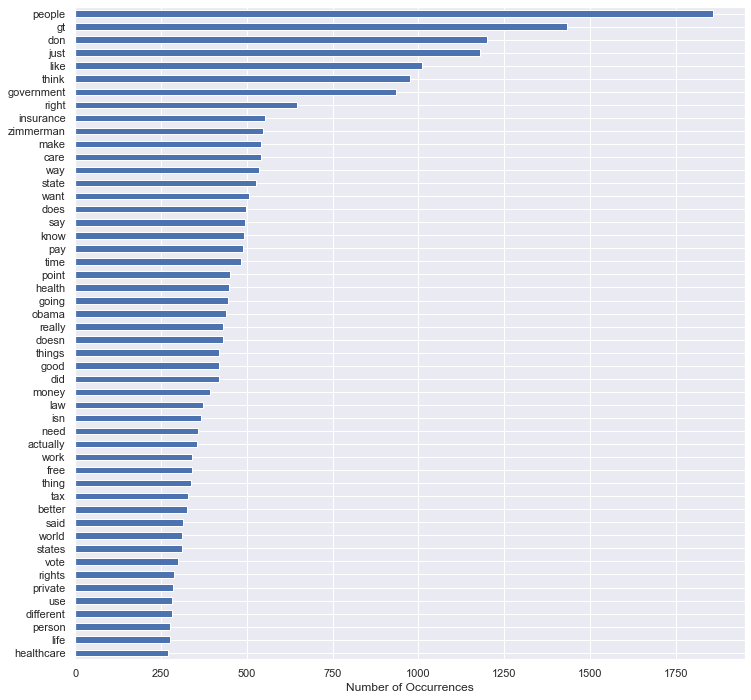

In [60]:
X_df = pd.DataFrame(X.todense(), columns = cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(12,12))
X_df.sum().sort_values(ascending=False).head(50).plot(kind='barh');
plt.xlabel('Number of Occurrences')
plt.gca().invert_yaxis()

Words to consider removing: _________

---
### Post word count


In [61]:
poli_dis_2012_counts = [len(post.split()) for post in poli_dis_2012_df['text']]
poli_dis_2020_counts = [len(post.split()) for post in poli_dis_2020_df['text']]

In [62]:
poli_dis_2012_counts[:10]

[19, 70, 16, 27, 12, 10, 16, 107, 66, 217]

In [63]:
poli_dis_2020_counts[:10]

[33, 96, 38, 96, 77, 81, 45, 61, 21, 165]

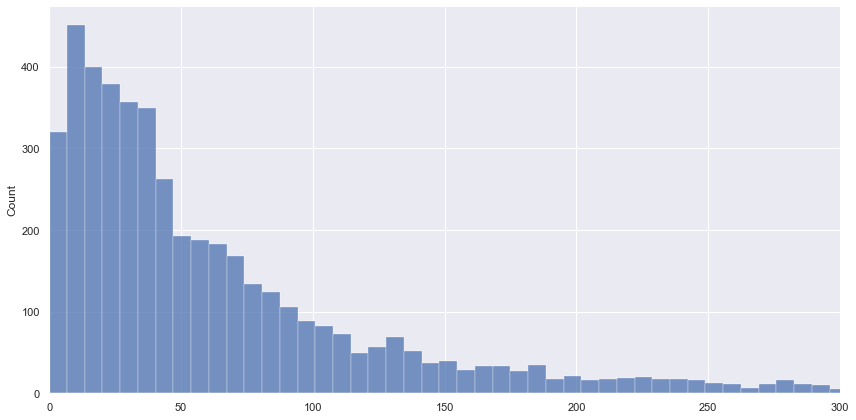

In [69]:
sns.displot(poli_dis_2012_counts, height = 6, aspect = 2, bins=250);
plt.xlim(0, 300);

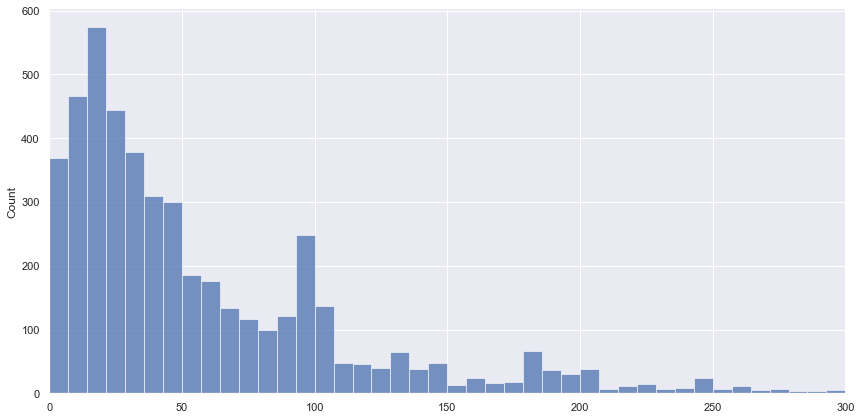

In [73]:
sns.displot(poli_dis_2020_counts, height = 6, aspect = 2, bins=125);
plt.xlim(0, 300);

---
### Post character length

In [74]:
poli_dis_2012_char_length = [len(post) for post in poli_dis_2012_df['text']]
poli_dis_2020_char_length = [len(post) for post in poli_dis_2020_df['text']]

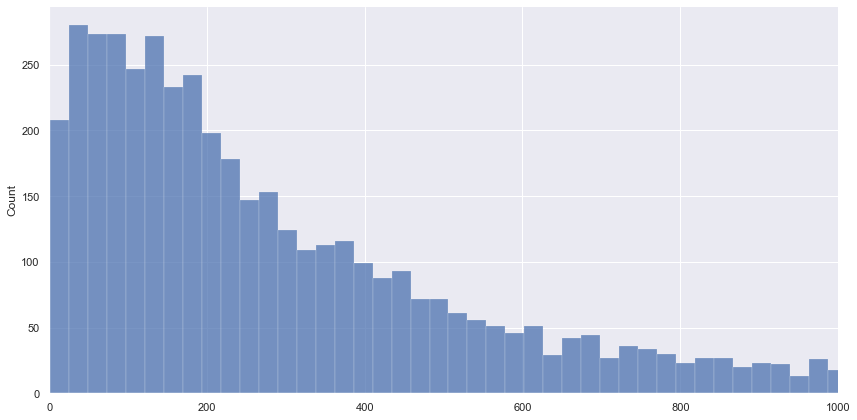

In [84]:
sns.displot(poli_dis_2012_char_length, height = 6, aspect = 2, bins=400);
plt.xlim(0, 1000);

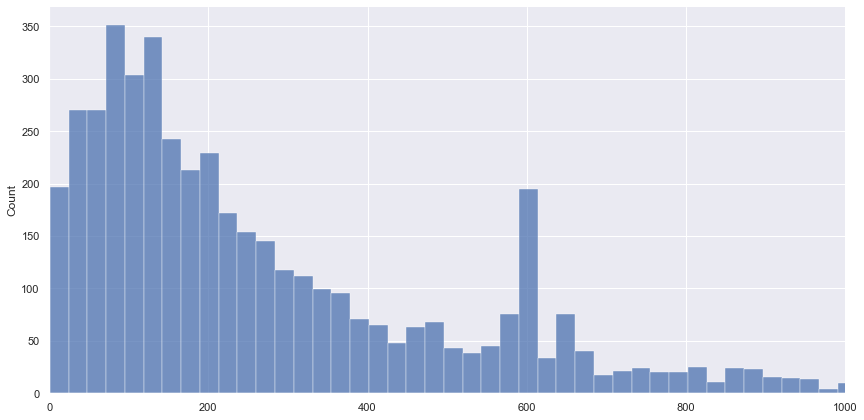

In [82]:
sns.displot(poli_dis_2020_char_length, height = 6, aspect = 2, bins=200);
plt.xlim(0, 1000);

---
### Sentiment analysis

In [85]:
poli_dis_2012_polarity = get_polarity(poli_dis_2012_df)
poli_dis_2012_polarity

{'Negative': 0.0993024091293325,
 'Neutral': 0.7756876584953505,
 'Positive': 0.12141018596787831}

In [91]:
# https://cmdlinetips.com/2018/01/how-to-create-pandas-dataframe-from-multiple-lists/
cols = list(zip(poli_dis_2012_polarity.keys(), poli_dis_2012_polarity.values()))

polarity_df = pd.DataFrame(cols, columns=['score_type', '2012'])

In [92]:
polarity_df

,score_type,2012
0,Negative,0.099302
1,Neutral,0.775688
2,Positive,0.121410


In [93]:
poli_dis_2020_polarity = get_polarity(poli_dis_2020_df)
poli_dis_2020_polarity

{'Negative': 0.0850539689206219,
 'Neutral': 0.791911591768163,
 'Positive': 0.1203074338513229}

In [94]:
polarity_df['2020'] = list(poli_dis_2020_polarity.values())

In [95]:
polarity_df

,score_type,2012,2020
0,Negative,0.099302,0.085054
1,Neutral,0.775688,0.791912
2,Positive,0.121410,0.120307


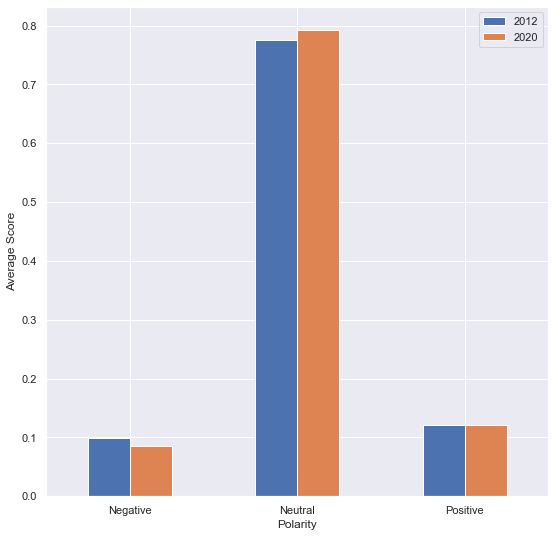

In [96]:
# https://stackoverflow.com/questions/42128467/matplotlib-plot-multiple-columns-of-pandas-data-frame-on-the-bar-chart
polarity_df.plot(x='score_type', y=['2012', '2020'], kind='bar', figsize=(9,9));
plt.xlabel('Polarity')
plt.ylabel('Average Score')
plt.xticks(rotation=0);

---
### Extra stuff
Thought about seeing how many words start with each letter of the alphabet for each of my subreddits. r/truezelda would have a lot more z words, it'd be cool! 

In [ ]:
letter_words_dict = {'s':[25333,10.6],
'p':[24472,10.3],
'c':[19851,8.37],
'a':[16869,7.11],
'u':[16520,6.97],
't':[12976,5.47],
'm':[12503,5.27],
'b':[11117,4.69],
'd':[11107,4.68],
'r':[9918,4.18],
'h':[9105,3.84],
'i':[8819,3.72],
'e':[8748,3.69],
'o':[7877,3.32],
'f':[7152,3.01],
'g':[6969,2.94],
'n':[6758,2.85],
'l':[6322,2.66],
'w':[4074,1.71],
'v':[3416,1.44],
'k':[2234,0.94],
'j':[1637,0.69],
'q':[1179,0.49],
'z':[963,0.40],
'y':[680,0.28],
'x':[384,0.16]}